In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import concurrent
from scipy.optimize import rosen

In [2]:
from pyBO import pyBO
from pyBO import Auto
from pyBO.model import GaussianProcess
from pyBO.covfunc import squaredExponential, matern52, matern32
from pyBO.util import proximal_ordered_init_sampler

In [3]:
# budget = 32
n_init = 32
n_context = 2
n_decision = 2
n_dim = n_context+n_decision

context_bounds = np.array(((-2,2),)*n_context)
decision_bounds = np.array(((-2,2),)*n_decision)
bounds = np.concatenate((decision_bounds,context_bounds),axis=0)

fixed_values_for_each_dim = {d+n_decision:0.0 for d in range(n_context)}

evaluation_wait_time = 4

In [4]:
def np_str(x,precision=3):
    return np.array2string(x, precision=precision)

In [5]:
def get_context(n=1):
    # allowed context to go out of expected context bounds by choosing bounds=2CL
    std = 0.5*(context_bounds[:,1]-context_bounds[:,0]) 
    off = 0.5*(context_bounds[:,0]+context_bounds[:,1])
    context = np.random.randn(n,n_context)*std.reshape(-1,n_context) + off.reshape(-1,n_context)
    return context.reshape(n,n_context)

### cost func

In [6]:
def bilog_inv_rosen(x):
    y = -rosen(x)
    return np.sign(y)*np.log(1+np.abs(y))

In [7]:
def bilog_inv_rosen_vec(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = bilog_inv_rosen(x[i,:])
    return y

In [8]:
def delayed_bilog_inv_rosen(x):
    time.sleep(evaluation_wait_time)
    return bilog_inv_rosen(x)

# asynchronous BO

##### init 

In [9]:
xc0 = get_context()
xd0 = np.random.rand(1,n_decision)*(decision_bounds[:,1]-decision_bounds[:,0])+decision_bounds[:,0]  # current context and set point
x0 = np.concatenate((xd0,xc0),axis=1)
y0 = bilog_inv_rosen_vec(x0)

##### assuming decision parameter polarity change is costly

In [10]:
train_cx = get_context(n_init)
train_dx = proximal_ordered_init_sampler(n_init,
                                         bounds=decision_bounds,
                                         x0=xd0,
                                         ramping_rate=np.ones(n_decision),
                                         polarity_change_time=10,
                                         method='sobol',
                                         seed=None)

train_x = np.concatenate((train_dx,train_cx),axis=1)
train_y = bilog_inv_rosen_vec(train_x)
train_x = np.concatenate((x0.reshape(1,-1),train_x),axis=0)
train_y = np.concatenate((y0,train_y),axis=0)

(-2.0, 2.0)

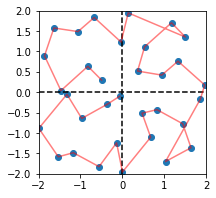

In [11]:
# check initial candidates are ordered to minimize ramping time including polarity change time
fig,ax=plt.subplots(figsize=(3,3))
ax.plot(train_x[:,0],train_x[:,1],alpha=0.5,c='r')
ax.scatter(train_x[:,0],train_x[:,1])
ax.hlines(0,bounds[0,0],bounds[0,1],ls='--',color='k')
ax.vlines(0,bounds[1,0],bounds[1,1],ls='--',color='k')
ax.set_xlim(bounds[0,0],bounds[0,1])
ax.set_ylim(bounds[1,0],bounds[1,1])

In [12]:
model = GaussianProcess(matern52())
bo = pyBO.BO(
            model = model,
            x = train_x, 
            y = train_y,
            bounds = bounds,
#             acquisition_func = 'UpperConfidenceBound'  # = UCB
            acquisition_func = 'ExpectedImprovement'  # = EI
         )

[████████████████████████████████████████] 100%/100%



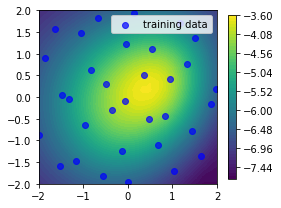

In [13]:
# plot initialized model with initial data. 
fig,ax = plt.subplots(figsize=(4,3))
# project maximum along the dimensions orthogonal to the porjected dimension
# projection dimensions are dim_xaxis=0,dim_yaxis=1 by default
# the goal of BO is maximization. 
bo.plot_model_2D_projection(project_maximum=True,
                            fig=fig,
                            ax=ax)
fig.tight_layout()

[████████████████████████████████████████] 100%/100%



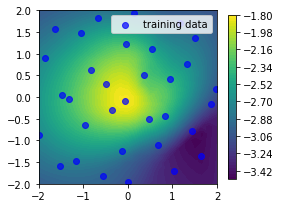

In [14]:
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(project_maximum=True,
                                  fig=fig,
                                  ax=ax)
fig.tight_layout()

In [15]:
##### remind bounds
bounds

array([[-2,  2],
       [-2,  2],
       [-2,  2],
       [-2,  2]])

###### test favor center

In [16]:
fixed_values_for_each_dim

{2: 0.0, 3: 0.0}

In [17]:
#default querry acquisition function is 'EI'
for i in range(n_context):
    fixed_values_for_each_dim[n_decision+i] = 0.0
x1 = bo.query_candidates(bounds = bounds,
                         X_favor = np.zeros(n_dim),
                         L_favor = 0.2,
                         C_favor = 100,
                         fixed_values_for_each_dim = fixed_values_for_each_dim
                         )
bo.remove_qeury_record()  # remove this test query record
x1  # resulting candidate is near the center (except the context)

array([[ 1.66787316e-04, -9.16431805e-06,  0.00000000e+00,
         0.00000000e+00]])

###### test penalize center

In [18]:
x1 = bo.query_candidates(bounds = bounds,
                         X_penal = np.zeros(n_dim),
                         L_penal = 1.0,
                         C_penal = 100,
                         fixed_values_for_each_dim = fixed_values_for_each_dim)
bo.remove_qeury_record() 
x1 # resulting candidate is far from the center

array([[2., 2., 0., 0.]])

###### 1st query 

In [19]:
# w/o penalization  
# defult bounds is same as the most recent one
context = get_context()
for c in range(n_context):
    fixed_values_for_each_dim[n_decision+c] = context.flatten()[c]
x1 = bo.query_candidates( X_current = train_x[-1:,:],  # this is used to impose polarity change penality
                          polarity_penalty = 0.5,
                          X_penal = Auto,  # this is used to penalize currently set point. L_penal, C_penal will be automatically selected based on data
                          X_favor = None,
                          fixed_values_for_each_dim = fixed_values_for_each_dim
                         )

executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
y1_future = executor.submit(delayed_bilog_inv_rosen,x1.flatten())  # asynchronous parallel objective evaluation

[████████████████████████████████████████] 100%/100%



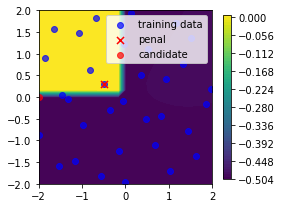

In [20]:
# check acuquisition functions
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(project_maximum=True,
                                  fixed_values_for_each_dim = fixed_values_for_each_dim,
                                  fig=fig,ax=ax)
fig.tight_layout()
ax.legend()

###### 2nd query while evaluating 1st candidate

In [21]:
context = get_context()
for c in range(n_context):
    fixed_values_for_each_dim[n_decision+c] = context.flatten()[c]
x2 = bo.query_candidates(
                         x_candidate = x1, 
                         y_candidate_future = y1_future, # this is used to stop optimization of query when the objective evaulation is done
                         X_current = Auto,  # if x_candidate is not None, X_current = x_candidate
                         polarity_penalty = 0.5,
                         X_penal = Auto,  # this will penalize near the X_current. L_penal, C_penal will be automatically selected based on data
                         X_favor = None,
                         fixed_values_for_each_dim = fixed_values_for_each_dim
                        )

[████████████████████████████████████████] 100%/100%



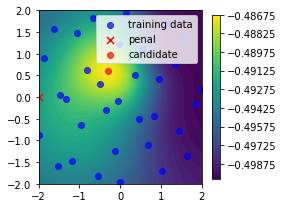

In [22]:
# check acuquisition functions
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(project_maximum=True,
                                  fixed_values_for_each_dim = fixed_values_for_each_dim,
                                  fig=fig,
                                  ax=ax)
fig.tight_layout()

###### get 1st candidate evaluated result and update model while evaluating 2nd candidate

In [23]:
y1 = [y1_future.result()]  # get the evaluated result of the 1st candidate that ran asynchronously
y2_future = executor.submit(delayed_bilog_inv_rosen,x2.flatten())  # asynchronous parallel objective evaluation for 2nd candidate
bo.update_model(x1=x1,y1=y1) # update model while evaluating the 2nd candidate

[████████████████████████████████████████] 100%/100%



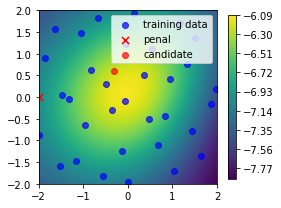

In [24]:
# plot updated model
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_model_2D_projection(epoch=-2,  # model updated. need to see previous querry
                            project_maximum=True,
                            fixed_values_for_each_dim = fixed_values_for_each_dim,
                            fig=fig,ax=ax)
fig.tight_layout()

###### get 2nd candidate evaluated result and update model while evaluating 3rd candidate

In [25]:
# following steps in this cell is wrapped in bo.step
y2 = [y2_future.result()]                  # get the evaluated result of the 2nd candidate that ran asynchronously

context = get_context()
for c in range(n_context):
    fixed_values_for_each_dim[n_decision+c] = context.flatten()[c]
x3 = bo.query_candidates(bounds=bounds,     
                         x_candidate = x2,
                         y_candidate_future = y2_future,
                         polarity_penalty = Auto,  # polarity_penalty is choosen by 10% of the current acquisition values on training data.
                         X_penal = Auto,  # this will penalize near the X_current as well as the training data points. L_penal, C_penal will be automatically selected based on data
                         X_favor = Auto,  # this will favor near the X_current (while penalizing same point but with larger length scale: L_favor > L_penal when both are automatically selected),
                         fixed_values_for_each_dim = fixed_values_for_each_dim
                        )

y3_future = executor.submit(delayed_bilog_inv_rosen,x3.flatten())  # asynchronous parallel objective evaluation for 3rd candidate

bo.update_model(x1=x2,y1=y2) # update model while evaluating the 3rd candidate

[████████████████████████████████████████] 100%/100%



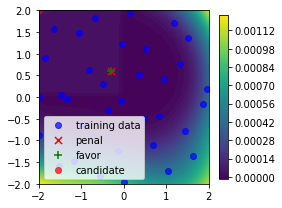

In [26]:
# check acuquisition functions
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(epoch=-2,
                                  project_maximum=True,
                                  fixed_values_for_each_dim=fixed_values_for_each_dim,
                                  fig=fig,ax=ax)
fig.tight_layout()

###### get 3rd candidate evaluated result and update model while evaluating 4th candidate using bo.step

In [27]:
context = get_context()
for c in range(n_context):
    fixed_values_for_each_dim[n_decision+c] = context.flatten()[c]
x4,y4_future = bo.step(delayed_bilog_inv_rosen,x3,y3_future,
                      polarity_penalty = Auto,
                      X_penal = Auto, 
                      X_favor = Auto,
                      fixed_values_for_each_dim = fixed_values_for_each_dim
                      )

[████████████████████████████████████████] 100%/100%



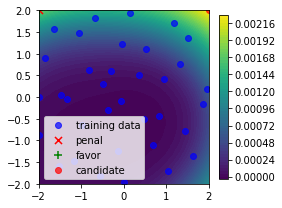

In [28]:
# check acuquisition functions
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(epoch=-2,
                                  project_maximum=True,
                                  fixed_values_for_each_dim=fixed_values_for_each_dim,
                                  fig=fig,ax=ax)
fig.tight_layout()

###### more looping using bo.step

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



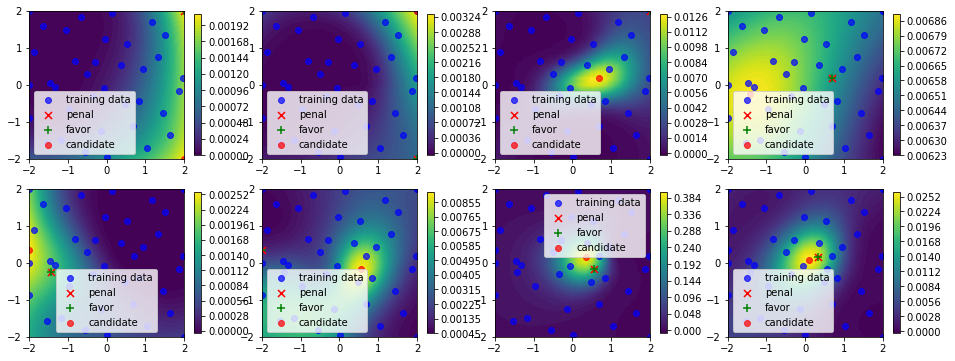

In [29]:
x = x4
y_future = y4_future
fig,ax = plt.subplots(2,4,figsize=(16,6))
for i in range(2):
    for j in range(4):
        context = get_context()
        for c in range(n_context):
            fixed_values_for_each_dim[n_decision+c] = context.flatten()[c]
        x,y_future = bo.step(delayed_bilog_inv_rosen,x,y_future,
                            polarity_penalty = Auto,
                            X_penal = Auto,
                            X_favor = Auto,
                            fixed_values_for_each_dim = fixed_values_for_each_dim,
                            )
        bo.plot_acquisition_2D_projection(epoch=-2, 
                                          fixed_values_for_each_dim = fixed_values_for_each_dim,
                                          fig=fig,ax=ax[i,j])

In [30]:
for i in range(8):
    context = get_context()
    for c in range(n_context):
        fixed_values_for_each_dim[n_decision+c] = context.flatten()[c]
    x,y_future = bo.step(delayed_bilog_inv_rosen,x,y_future,
                        polarity_penalty = 0.5,
                        X_penal = Auto,
                        X_favor = Auto,
                        fixed_values_for_each_dim = fixed_values_for_each_dim
                        )

In [31]:
# pyBO compuation time is more or less the objective evaluation time 
#   -- except the 1st query when there is no pending point 
#   -- and also when evaluation time is shoter than single optmization loop over acquisition function).
# pyBO stops query loop when objective evaulation is done.
for hist in bo.history:
    print(hist['model_fit_time']+np.sum(hist['query_time']) < evaluation_wait_time*1.1)

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


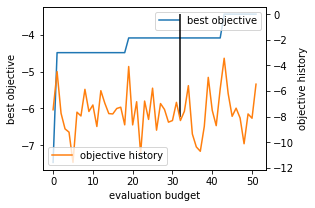

In [32]:
bo.plot_obj_history()
plt.vlines(n_init,-8,0,color='k')

In [33]:
x,y = bo.best_sofar()
x,y

(array([ 0.33987234,  0.15182407, -0.13258727,  0.52072171]),
 array([-3.44385148]))